<font color="red">注</font>: 使用 tensorboard 可视化需要安装 tensorflow (TensorBoard依赖于tensorflow库，可以任意安装tensorflow的gpu/cpu版本)

```shell
pip install tensorflow-cpu
```

In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import sklearn
import pandas as pd
import os
import sys
import time
from tqdm.auto import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F

print(sys.version_info)
for module in mpl, np, pd, sklearn, torch:
    print(module.__name__, module.__version__)

device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
print(device)

seed = 42


/usr/local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


sys.version_info(major=3, minor=10, micro=14, releaselevel='final', serial=0)
matplotlib 3.10.0
numpy 1.26.4
pandas 2.2.3
sklearn 1.6.0
torch 2.5.1+cu124
cuda:0


In [2]:
!pip install kaggle

Looking in indexes: https://mirrors.cloud.aliyuncs.com/pypi/simple
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.7/82.7 kB 12.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 163.4/163.4 kB 12.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.2/78.2 kB 21.7 MB/s eta 0:00:00
  Created wheel for kaggle: filename=kaggle-1.6.17-py3-none-any.whl size=105800 sha256=7327c5b8a61e75182be698c17a4e4ff8bf56fe8970b663039c65b1fb6d136206
  Stored in directory: /root/.cache/pip/wheels/85/59/78/39b001621fad138a41610d830155c8b08d48649b2197e433c7
Successfully built kaggle

[notice] A new release of pip is available: 23.3.2 -> 25.0
[notice] To update, run: pip install --upgrade pip


In [3]:
!pwd

/mnt/workspace


In [4]:
!rm -r /content/datasets/

rm: 无法删除 '/content/datasets/': 没有那个文件或目录


In [5]:
# 导入Python内置的json模块，该模块提供了处理JSON数据的方法
import json

# 定义一个包含Kaggle账号凭证的Python字典
# 通常用于API身份验证，其中：
# - "username"：Kaggle平台注册的用户名
# - "key"：Kaggle账户的API密钥（用于命令行工具认证）
token = {"username":"chizaoyaowan123","key":"5a374c8b00ade92b48c3c99f5c96a58b"}

# 使用with语句安全地操作文件：
# 1. 打开/mnt/workspace/kaggle.json文件，'w'表示写入模式（如果文件存在会被覆盖）
# 2. 将文件对象赋值给变量file
# （文件路径说明：通常在Linux系统中，/mnt/用于挂载点，workspace可能是工作目录）
with open('/mnt/workspace/kaggle.json', 'w') as file:
    # 使用json.dump()方法将token字典序列化为JSON格式
    # 并写入到已打开的文件对象中
    # 最终生成标准JSON格式文件，包含用户名和API密钥
    json.dump(token, file)

In [6]:
!cat /mnt/workspace/kaggle.json

{"username": "chizaoyaowan123", "key": "5a374c8b00ade92b48c3c99f5c96a58b"}

In [7]:
# 1. 创建一个名为 .kaggle 的文件夹到用户的主目录中
#    - 使用 "-p" 参数，即使该目录已经存在也不会报错，同时会自动创建任何不存在的父级目录
!mkdir -p ~/.kaggle

# 2. 将存放在 /mnt/workspace/ 下的 kaggle.json 文件复制到刚刚创建的 .kaggle 目录中
#    - kaggle.json 文件通常包含了你的 Kaggle API 密钥和配置信息
!cp /mnt/workspace/kaggle.json ~/.kaggle/

# 3. 修改 kaggle.json 文件的权限，设置为 600
#    - 权限 600 表示只有文件所有者具有读写权限，这样可以保证 API 密钥的安全，防止其他用户读取
!chmod 600 ~/.kaggle/kaggle.json

# 4. 使用 Kaggle 命令行工具设置配置项
#    - 此处设置 "path" 配置项的值为 /content，表示将来通过 Kaggle 工具下载的数据或文件默认存储到 /content 目录
!kaggle config set -n path -v /content


- path is now set to: /content


In [8]:
!kaggle datasets download -d slothkong/10-monkey-species

Dataset URL: https://www.kaggle.com/datasets/slothkong/10-monkey-species
License(s): CC0-1.0
100%|███████████████████████████████████████▉| 547M/547M [01:28<00:00, 5.73MB/s]
100%|████████████████████████████████████████| 547M/547M [01:28<00:00, 6.52MB/s]


In [9]:
# 这段命令主要是用于在 Linux 或类似 Unix 的环境中解压一个 zip 文件，并将解压后的内容放置在指定目录，同时覆盖已存在的同名文件，且不显示任何输出
!unzip -o -d /content /content/datasets/slothkong/10-monkey-species/10-monkey-species.zip >/dev/null 

## 数据准备

```shell
$ tree -L 2 archive
archive
├── monkey_labels.txt
├── training
│   ├── n0
│   ├── n1
│   ├── n2
│   ├── n3
│   ├── n4
│   ├── n5
│   ├── n6
│   ├── n7
│   ├── n8
│   └── n9
└── validation
    ├── n0
    ├── n1
    ├── n2
    ├── n3
    ├── n4
    ├── n5
    ├── n6
    ├── n7
    ├── n8
    └── n9

22 directories, 1 file
```

In [10]:
!ls

01-classification_model-cnn-Aliyun.ipynb     checkpoints
02_classification_model-cnn-selu.ipynb	     data
03_classification_model-separable_cnn.ipynb  kaggle.json
04_10_monkeys_model_1_aliyun.ipynb	     runs
04_10_monkeys_model_2.ipynb


In [11]:
# 从 torchvision 包中导入 datasets 模块，用于处理数据集相关操作
from torchvision import datasets
# 从 torchvision.transforms 中导入多种数据预处理操作：
# ToTensor：将图片转换为张量格式；Resize：调整图片尺寸；
# Compose：将多个转换操作组合；ConvertImageDtype：转换张量的数据类型；
# Normalize：对图片进行归一化处理
from torchvision.transforms import ToTensor, Resize, Compose, ConvertImageDtype, Normalize

# 从 pathlib 模块中导入 Path 类，用于方便地操作文件路径
from pathlib import Path

# 定义两个数据目录常量：
# DATA_DIR1 指向训练数据存放的根目录，通常在云平台或本地文件系统中指定路径
DATA_DIR1 = Path("/content/training/")
# DATA_DIR2 指向验证数据存放的根目录
DATA_DIR2 = Path("/content/validation/")

# 定义一个自定义数据集类 MonkeyDataset，该类继承自 torchvision.datasets.ImageFolder
# ImageFolder 是一个便捷的类，可以自动将文件夹中按子文件夹存放的图片视为不同类别进行加载
class MonkeyDataset(datasets.ImageFolder):
    # 定义构造函数，参数 mode 指定加载哪种数据（训练集或验证集），transform 为预处理操作
    def __init__(self, mode, transform=None):
        # 根据 mode 参数判断需要加载的数据类型
        if mode == "train":
            # 如果 mode 为 "train"，则构造训练集的路径
            # 注意：此处 DATA_DIR1 / "training" 表示在 DATA_DIR1 路径下的 "training" 子文件夹
            root = DATA_DIR1 / "training"
        elif mode == "val":
            # 如果 mode 为 "val"，则构造验证集的路径
            # 同理，DATA_DIR2 / "validation" 表示在 DATA_DIR2 路径下的 "validation" 子文件夹
            root = DATA_DIR2 / "validation"
        else:
            # 如果 mode 参数既不是 "train" 也不是 "val"，则抛出异常，提醒用户 mode 参数输入错误
            raise ValueError("mode should be one of the following: train, val, but got {}".format(mode))
        # 调用父类 ImageFolder 的构造函数，将确定好的根目录 root 和传入的 transform 参数传递给父类
        super().__init__(root, transform) # 调用父类init方法
        # 将父类 ImageFolder 解析后的 samples 赋值给 self.imgs
        # self.samples 是一个列表，每个元素为 (图片路径, 标签) 的元组，便于后续处理
        self.imgs = self.samples
        # 从 samples 中提取所有标签，生成一个标签列表，存放于 self.targets 中
        # 通过列表解析提取每个样本元组中第二个元素（标签）
        self.targets = [s[1] for s in self.samples] # 标签取出来

# 定义预处理过程中目标图片的尺寸，这里将图片统一调整为 128 像素的高度和 128 像素的宽度
img_h, img_w = 128, 128

# 定义一个复合的图片预处理操作 transform，通过 Compose 将多个转换操作依次组合：
transform = Compose([
    # Resize 操作：将输入图片调整为 (img_h, img_w) 指定的尺寸
    Resize((img_h, img_w)), # 图片缩放
    # ToTensor 操作：将图片转换为 PyTorch 张量，并自动将图片像素值归一化到 [0, 1] 的范围内
    ToTensor(),
    # Normalize 操作：使用给定的均值和标准差对图片进行归一化
    # 此处的均值 [0.4363, 0.4328, 0.3291] 和标准差 [0.2085, 0.2032, 0.1988] 是预先统计得到的
    Normalize([0.4363, 0.4328, 0.3291], [0.2085, 0.2032, 0.1988]),
    # ConvertImageDtype 操作：将图片张量的数据类型转换为 torch.float
    # 注意：此处需要确保已导入 torch 库，否则可能会报错；不过由于不修改代码，这里仅作说明
    ConvertImageDtype(torch.float), # 转换为float类型
]) # 数据预处理的组合

# 根据上面自定义的 MonkeyDataset 类，创建训练集数据对象
# 参数 "train" 指定加载训练集，同时传入预处理操作 transform
train_ds = MonkeyDataset("train", transform=transform)
# 同理，创建验证集数据对象，参数 "val" 指定加载验证集
val_ds = MonkeyDataset("val", transform=transform)

# 打印训练集加载的图片数量，通过 len(train_ds) 获取图片总数
print("load {} images from training dataset".format(len(train_ds)))
# 打印验证集加载的图片数量，通过 len(val_ds) 获取图片总数
print("load {} images from validation dataset".format(len(val_ds)))


load 1097 images from training dataset
load 272 images from validation dataset


In [12]:
# 数据类别
train_ds.classes

['n0', 'n1', 'n2', 'n3', 'n4', 'n5', 'n6', 'n7', 'n8', 'n9']

In [13]:
train_ds.class_to_idx

{'n0': 0,
 'n1': 1,
 'n2': 2,
 'n3': 3,
 'n4': 4,
 'n5': 5,
 'n6': 6,
 'n7': 7,
 'n8': 8,
 'n9': 9}

In [14]:
# 图片路径 及 标签
for fpath, label in train_ds.imgs:
    print(fpath, label)
    break

#这个和之前的dataset完全一致
for img, label in train_ds:
    # c, h, w  label
    print(img, label)
    break

/content/training/training/n0/n0018.jpg 0
tensor([[[-0.1553, -0.0236,  0.3525,  ...,  1.1425,  1.8384,  0.9920],
         [-0.1365, -0.1365,  0.1833,  ...,  0.8416,  1.9324,  0.9356],
         [-0.1177, -0.1741,  0.1268,  ...,  1.1425,  1.3306,  1.3494],
         ...,
         [ 2.1205,  2.1205,  2.0641,  ...,  0.9920,  0.8416,  0.3713],
         [ 2.0641,  1.9136,  1.6691,  ...,  0.3713, -0.0612, -0.0048],
         [ 1.9513,  1.6691,  1.2553,  ...,  0.0328, -0.4938, -0.1365]],

        [[-0.2193, -0.0456,  0.3983,  ...,  1.3632,  2.0580,  1.0737],
         [-0.2386, -0.2000,  0.2053,  ...,  0.9386,  2.1545,  1.1702],
         [-0.2772, -0.2772,  0.0702,  ...,  1.1702,  1.5176,  1.6527],
         ...,
         [ 2.4054,  2.3668,  2.2703,  ...,  0.6491,  0.5333,  0.1088],
         [ 2.2896,  2.1352,  1.8650,  ...,  0.0509, -0.3351, -0.3544],
         [ 2.1352,  1.8457,  1.4211,  ..., -0.3544, -0.8369, -0.5667]],

        [[-0.7283, -0.4324,  0.2975,  ...,  0.2383,  0.9287, -0.3141],
   

## 这里是是对三个通道的均值方差进行统计，分别是R、G、B通道的均值方差

In [15]:
def cal_mean_std(ds):
    mean = 0.
    std = 0.
    for img, _ in ds:
        mean += img[0:1, :, :].mean(dim=(1, 2))
        std += img[0:1, :, :].std(dim=(1, 2))
    mean /= len(ds)
    std /= len(ds)
    return mean, std

# 经过 normalize 后 均值为0，方差为1
print(cal_mean_std(train_ds))

(tensor([0.0002]), tensor([0.9999]))


In [16]:
def cal_mean_std(ds):
    mean = 0.
    std = 0.
    for img, _ in ds:
        mean += img[1:2, :, :].mean(dim=(1, 2))
        std += img[1:2, :, :].std(dim=(1, 2))
    mean /= len(ds)
    std /= len(ds)
    return mean, std

# 经过 normalize 后 均值为0，方差为1
print(cal_mean_std(train_ds))

(tensor([3.6267e-05]), tensor([0.9999]))


In [17]:
def cal_mean_std(ds):
    mean = 0.
    std = 0.
    for img, _ in ds:
        mean += img[2:3, :, :].mean(dim=(1, 2))
        std += img[2:3, :, :].std(dim=(1, 2))
    mean /= len(ds)
    std /= len(ds)
    return mean, std

# 经过 normalize 后 均值为0，方差为1
print(cal_mean_std(train_ds))

(tensor([-6.5391e-07]), tensor([1.0002]))


In [18]:
# 遍历train_ds得到每张图片，计算每个通道的均值和方差
def cal_mean_std(ds):
    mean = 0.
    std = 0.
    for img, _ in ds:
        mean += img.mean(dim=(1, 2)) #dim=(1, 2)表示计算均值后，宽和高消除（把宽和高所有的像素加起来，再除以总数）
        std += img.std(dim=(1, 2))
    mean /= len(ds)
    std /= len(ds)
    return mean, std

# 经过 normalize 后 均值为0，方差为1
# print(cal_mean_std(train_ds))

In [19]:
import torch.nn as nn
from torch.utils.data.dataloader import DataLoader

batch_size = 64
# 从数据集到dataloader
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=4) #训练集
val_loader = DataLoader(val_ds, batch_size=batch_size, shuffle=False, num_workers=4) #验证集

## 定义模型

In [20]:
# 定义一个卷积神经网络模型，继承自 PyTorch 的 nn.Module
class CNN(nn.Module):
    # 构造函数，num_classes 表示分类的类别数，activation 用于选择激活函数（"relu" 或 "selu"）
    def __init__(self, num_classes=10, activation="relu"):
        super(CNN, self).__init__()
        # 根据 activation 参数选择激活函数
        # 如果 activation == "relu"，则使用 F.relu，否则使用 F.selu
        self.activation = F.relu if activation == "relu" else F.selu

        # 定义第一层卷积层：
        # 输入通道数为3（例如RGB图像），输出通道数为32，卷积核大小为3x3
        # padding="same" 表示边缘填充，使得输出的宽高与输入保持一致
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding="same")
        
        # 定义第二层卷积层：
        # 输入通道数为32（上一层输出），输出通道数仍为32，卷积核同样为3x3，padding="same"
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, padding="same")
        
        # 定义池化层：
        # 使用最大池化，窗口大小为2x2，步长为2，将特征图的宽和高各缩小一半
        self.pool = nn.MaxPool2d(2, 2)
        
        # 定义第三层卷积层：
        # 输入通道数为32，输出通道数为64，卷积核大小为3x3，padding="same"
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding="same")
        
        # 定义第四层卷积层：
        # 输入通道数为64，输出通道数仍为64，卷积核大小为3x3，padding="same"
        self.conv4 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding="same")
        
        # 定义第五层卷积层：
        # 输入通道数为64，输出通道数为128，卷积核大小为3x3，padding="same"
        self.conv5 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding="same")
        
        # 定义第六层卷积层：
        # 输入通道数为128，输出通道数仍为128，卷积核大小为3x3，padding="same"
        self.conv6 = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding="same")
        
        # 定义展平层，将多维张量展平成一维向量，便于后续全连接层处理
        self.flatten = nn.Flatten()
        # 定义第一个全连接层 fc1：
        # 经过三次池化后，假设输入图像尺寸为 (3, 128, 128)，尺寸会变成 (128, 16, 16)
        # 所以展平后的特征数为 128 * 16 * 16，映射到 128 维特征
        self.fc1 = nn.Linear(128 * 16 * 16, 128)
        
        # 定义第二个全连接层 fc2：
        # 将 fc1 输出的 128 维特征映射到最终分类的类别数（num_classes）
        self.fc2 = nn.Linear(128, num_classes)

        # 初始化模型中所有全连接层和卷积层的权重
        self.init_weights()

    # 定义权重初始化函数，使用 Xavier 均匀分布来初始化权重
    def init_weights(self):
        """使用 xavier 均匀分布来初始化全连接层、卷积层的权重 W"""
        # 遍历模型的所有子模块
        for m in self.modules():
            # 判断当前子模块是否为全连接层或卷积层
            if isinstance(m, (nn.Linear, nn.Conv2d)):
                # 使用 Xavier 均匀分布初始化权重，能使得网络更容易训练和收敛
                nn.init.xavier_uniform_(m.weight)
                # 将偏置初始化为 0
                nn.init.zeros_(m.bias)

    # 定义前向传播函数，描述输入数据如何经过各层处理得到输出
    def forward(self, x):
        # 简写激活函数为 act，便于后续调用
        act = self.activation
        
        # 第一组卷积操作：
        # 依次经过 conv1 -> 激活 -> conv2 -> 激活，再经过最大池化层 pool
        # 这一组操作会提取低级特征，并将特征图尺寸缩小一半
        x = self.pool(act(self.conv2(act(self.conv1(x)))))
        
        # 第二组卷积操作：
        # 使用 conv3 和 conv4 进行两次卷积操作，每次卷积后均经过激活函数，最后再进行池化
        x = self.pool(act(self.conv4(act(self.conv3(x)))))
        
        # 第三组卷积操作：
        # 使用 conv5 和 conv6 进行两次卷积操作，激活后进行池化，进一步提取更高级的特征
        x = self.pool(act(self.conv6(act(self.conv5(x)))))
        
        # 将卷积层输出的多维张量展平成一维向量
        x = self.flatten(x)
        
        # 第一个全连接层 fc1，将展平后的特征映射到 128 维特征，并经过激活函数
        x = act(self.fc1(x))
        
        # 第二个全连接层 fc2，将特征映射到最终分类结果（类别数）
        x = self.fc2(x)
        
        # 返回最终输出结果
        return x

# 遍历模型的所有参数，打印每个参数的名称及其参数数量
# 例如，卷积层和全连接层中的权重和偏置参数的数量
for idx, (key, value) in enumerate(CNN().named_parameters()):
    print(f"{key}\tparamerters num: {np.prod(value.shape)}")


conv1.weight	paramerters num: 864
conv1.bias	paramerters num: 32
conv2.weight	paramerters num: 9216
conv2.bias	paramerters num: 32
conv3.weight	paramerters num: 18432
conv3.bias	paramerters num: 64
conv4.weight	paramerters num: 36864
conv4.bias	paramerters num: 64
conv5.weight	paramerters num: 73728
conv5.bias	paramerters num: 128
conv6.weight	paramerters num: 147456
conv6.bias	paramerters num: 128
fc1.weight	paramerters num: 4194304
fc1.bias	paramerters num: 128
fc2.weight	paramerters num: 1280
fc2.bias	paramerters num: 10


## 训练

pytorch的训练需要自行实现，包括
1. 定义损失函数
2. 定义优化器
3. 定义训练步
4. 训练

In [21]:
# 从 scikit-learn 库中导入 accuracy_score 函数，用于计算分类准确率
from sklearn.metrics import accuracy_score

# 使用 @torch.no_grad() 装饰器，表示在该函数内部不需要计算梯度，
# 这在验证或测试时可以节省内存和计算资源，避免梯度追踪
@torch.no_grad()
def evaluating(model, dataloader, loss_fct):
    # 初始化一个列表，用于存储每个 batch 计算得到的损失值
    loss_list = []
    # 初始化一个列表，用于存储所有 batch 的预测标签
    pred_list = []
    # 初始化一个列表，用于存储所有 batch 的真实标签
    label_list = []
    
    # 遍历 dataloader 中的所有数据，dataloader 会按 batch 返回数据和对应的标签
    for datas, labels in dataloader:
        # 将输入数据 datas 移动到指定设备上（例如 GPU 或 CPU），device 需在其他地方定义
        datas = datas.to(device)
        # 同样，将标签数据也移动到相同设备上，确保数据和标签在同一设备上计算
        labels = labels.to(device)
        
        # 前向计算：将输入数据通过模型得到输出 logits
        logits = model(datas)
        # 计算当前 batch 的损失值，loss_fct 是预先定义的损失函数（例如交叉熵损失）
        # logits 为模型预测的原始输出，labels 为真实标签
        loss = loss_fct(logits, labels)         # 验证集损失
        
        # 将当前 batch 的损失值（通过 loss.item() 转换为 Python 数值）添加到 loss_list 中
        loss_list.append(loss.item())

        # 预测：对 logits 的最后一个维度（即各类别得分）取最大值的索引，
        # 得到当前 batch 的预测类别标签
        preds = logits.argmax(axis=-1)    # 验证集预测
        
        # 将预测的标签从 GPU（或当前设备）上移回 CPU，再转换为 numpy 数组，
        # 最后转换为 Python 的 list，并将这些预测值扩展到 pred_list 中
        pred_list.extend(preds.cpu().numpy().tolist())
        # 同样的，将真实标签从设备移回 CPU，转换为 numpy 数组，再转换为 list，
        # 将这些真实标签扩展到 label_list 中
        label_list.extend(labels.cpu().numpy().tolist())

    # 使用 accuracy_score 函数计算所有 batch 累积的真实标签和预测标签之间的分类准确率
    acc = accuracy_score(label_list, pred_list)
    # 返回所有 batch 损失值的平均值（即验证集的平均损失）和计算得到的准确率
    return np.mean(loss_list), acc


### TensorBoard 可视化


训练过程中可以使用如下命令启动tensorboard服务。

```shell
tensorboard \
    --logdir=runs \     # log 存放路径
    --host 0.0.0.0 \    # ip
    --port 8848         # 端口
```

In [22]:
from torch.utils.tensorboard import SummaryWriter


class TensorBoardCallback:
    def __init__(self, log_dir, flush_secs=10):
        """
        Args:
            log_dir (str): dir to write log.
            flush_secs (int, optional): write to dsk each flush_secs seconds. Defaults to 10.
        """
        self.writer = SummaryWriter(log_dir=log_dir, flush_secs=flush_secs)

    def draw_model(self, model, input_shape):
        self.writer.add_graph(model, input_to_model=torch.randn(input_shape))

    def add_loss_scalars(self, step, loss, val_loss):
        self.writer.add_scalars(
            main_tag="training/loss",
            tag_scalar_dict={"loss": loss, "val_loss": val_loss},
            global_step=step,
            )

    def add_acc_scalars(self, step, acc, val_acc):
        self.writer.add_scalars(
            main_tag="training/accuracy",
            tag_scalar_dict={"accuracy": acc, "val_accuracy": val_acc},
            global_step=step,
        )

    def add_lr_scalars(self, step, learning_rate):
        self.writer.add_scalars(
            main_tag="training/learning_rate",
            tag_scalar_dict={"learning_rate": learning_rate},
            global_step=step,

        )

    def __call__(self, step, **kwargs):
        # add loss
        loss = kwargs.pop("loss", None)
        val_loss = kwargs.pop("val_loss", None)
        if loss is not None and val_loss is not None:
            self.add_loss_scalars(step, loss, val_loss)
        # add acc
        acc = kwargs.pop("acc", None)
        val_acc = kwargs.pop("val_acc", None)
        if acc is not None and val_acc is not None:
            self.add_acc_scalars(step, acc, val_acc)
        # add lr
        learning_rate = kwargs.pop("lr", None)
        if learning_rate is not None:
            self.add_lr_scalars(step, learning_rate)


### Save Best


In [23]:
class SaveCheckpointsCallback:
    def __init__(self, save_dir, save_step=5000, save_best_only=True):
        """
        Save checkpoints each save_epoch epoch.
        We save checkpoint by epoch in this implementation.
        Usually, training scripts with pytorch evaluating model and save checkpoint by step.

        Args:
            save_dir (str): dir to save checkpoint
            save_epoch (int, optional): the frequency to save checkpoint. Defaults to 1.
            save_best_only (bool, optional): If True, only save the best model or save each model at every epoch.
        """
        self.save_dir = save_dir
        self.save_step = save_step
        self.save_best_only = save_best_only
        self.best_metrics = -1

        # mkdir
        if not os.path.exists(self.save_dir):
            os.mkdir(self.save_dir)

    def __call__(self, step, state_dict, metric=None):
        if step % self.save_step > 0:
            return

        if self.save_best_only:
            assert metric is not None
            if metric >= self.best_metrics:
                # save checkpoints
                torch.save(state_dict, os.path.join(self.save_dir, "best.ckpt"))
                # update best metrics
                self.best_metrics = metric
        else:
            torch.save(state_dict, os.path.join(self.save_dir, f"{step}.ckpt"))



### Early Stop

In [24]:
class EarlyStopCallback:
    def __init__(self, patience=5, min_delta=0.01):
        """

        Args:
            patience (int, optional): Number of epochs with no improvement after which training will be stopped.. Defaults to 5.
            min_delta (float, optional): Minimum change in the monitored quantity to qualify as an improvement, i.e. an absolute
                change of less than min_delta, will count as no improvement. Defaults to 0.01.
        """
        self.patience = patience
        self.min_delta = min_delta
        self.best_metric = -1
        self.counter = 0

    def __call__(self, metric):
        if metric >= self.best_metric + self.min_delta:
            # update best metric
            self.best_metric = metric
            # reset counter
            self.counter = 0
        else:
            self.counter += 1

    @property
    def early_stop(self):
        return self.counter >= self.patience


In [25]:
# 训练
def training(
    model,
    train_loader,
    val_loader,
    epoch,
    loss_fct,
    optimizer,
    tensorboard_callback=None,
    save_ckpt_callback=None,
    early_stop_callback=None,
    eval_step=500,
    ):
    record_dict = {
        "train": [],
        "val": []
    }

    global_step = 0
    model.train()
    with tqdm(total=epoch * len(train_loader)) as pbar:
        for epoch_id in range(epoch):
            # training
            for datas, labels in train_loader:
                datas = datas.to(device)
                labels = labels.to(device)
                # 梯度清空
                optimizer.zero_grad()
                # 模型前向计算
                logits = model(datas)
                # 计算损失
                loss = loss_fct(logits, labels)
                # 梯度回传
                loss.backward()
                # 调整优化器，包括学习率的变动等
                optimizer.step()
                preds = logits.argmax(axis=-1)

                acc = accuracy_score(labels.cpu().numpy(), preds.cpu().numpy())
                loss = loss.cpu().item()
                # record

                record_dict["train"].append({
                    "loss": loss, "acc": acc, "step": global_step
                })

                # evaluating
                if global_step % eval_step == 0:
                    model.eval()
                    val_loss, val_acc = evaluating(model, val_loader, loss_fct)
                    record_dict["val"].append({
                        "loss": val_loss, "acc": val_acc, "step": global_step
                    })
                    model.train()

                    # 1. 使用 tensorboard 可视化
                    if tensorboard_callback is not None:
                        tensorboard_callback(
                            global_step,
                            loss=loss, val_loss=val_loss,
                            acc=acc, val_acc=val_acc,
                            lr=optimizer.param_groups[0]["lr"],
                            )

                    # 2. 保存模型权重 save model checkpoint
                    if save_ckpt_callback is not None:
                        save_ckpt_callback(global_step, model.state_dict(), metric=val_acc)

                    # 3. 早停 Early Stop
                    if early_stop_callback is not None:
                        early_stop_callback(val_acc)
                        if early_stop_callback.early_stop:
                            print(f"Early stop at epoch {epoch_id} / global_step {global_step}")
                            return record_dict

                # udate step
                global_step += 1
                pbar.update(1)
                pbar.set_postfix({"epoch": epoch_id})

    return record_dict


epoch = 20

activation = "relu"
model = CNN(num_classes=10, activation=activation)

# 1. 定义损失函数 采用交叉熵损失
loss_fct = nn.CrossEntropyLoss()
# 2. 定义优化器 采用 adam
# Optimizers specified in the torch.optim package
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, eps=1e-7)

# 1. tensorboard 可视化
if not os.path.exists("runs"):
    os.mkdir("runs")
tensorboard_callback = TensorBoardCallback(f"runs/monkeys-cnn-{activation}")
tensorboard_callback.draw_model(model, [1, 3, img_h, img_w])
# 2. save best
if not os.path.exists("checkpoints"):
    os.makedirs("checkpoints")
save_ckpt_callback = SaveCheckpointsCallback(f"checkpoints/monkeys-cnn-{activation}", save_step=len(train_loader), save_best_only=True)
# 3. early stop
early_stop_callback = EarlyStopCallback(patience=5)

model = model.to(device)
record = training(
    model,
    train_loader,
    val_loader,
    epoch,
    loss_fct,
    optimizer,
    tensorboard_callback=None,
    save_ckpt_callback=save_ckpt_callback,
    early_stop_callback=early_stop_callback,
    eval_step=len(train_loader)
    )

 80%|████████  | 288/360 [01:37<00:24,  2.95it/s, epoch=15]

Early stop at epoch 16 / global_step 288


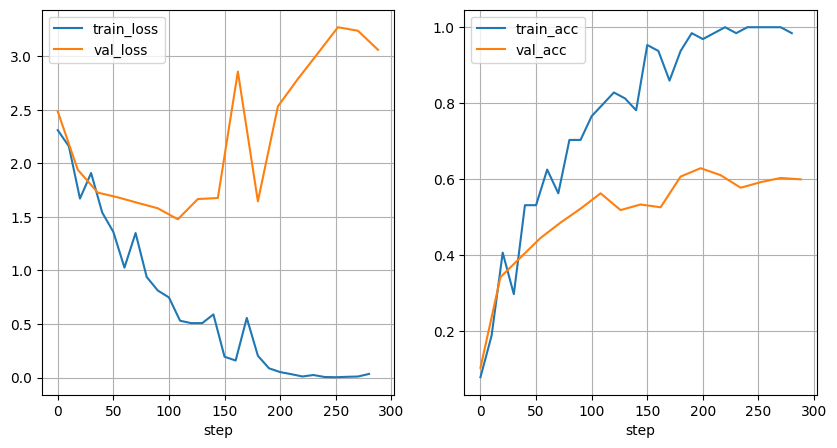

In [26]:
#画线要注意的是损失是不一定在零到1之间的
def plot_learning_curves(record_dict, sample_step=500):
    # build DataFrame
    train_df = pd.DataFrame(record_dict["train"]).set_index("step").iloc[::sample_step]
    val_df = pd.DataFrame(record_dict["val"]).set_index("step")

    # plot
    fig_num = len(train_df.columns)
    fig, axs = plt.subplots(1, fig_num, figsize=(5 * fig_num, 5))
    for idx, item in enumerate(train_df.columns):
        axs[idx].plot(train_df.index, train_df[item], label=f"train_{item}")
        axs[idx].plot(val_df.index, val_df[item], label=f"val_{item}")
        axs[idx].grid()
        axs[idx].legend()
        # axs[idx].set_xticks(range(0, train_df.index[-1], 5000))
        # axs[idx].set_xticklabels(map(lambda x: f"{int(x/1000)}k", range(0, train_df.index[-1], 5000)))
        axs[idx].set_xlabel("step")

    plt.show()

plot_learning_curves(record, sample_step=10)  #横坐标是 steps

# 评估

In [27]:
# dataload for evaluating

# load checkpoints
model.load_state_dict(torch.load(f"checkpoints/monkeys-cnn-{activation}/best.ckpt", map_location="cpu"))

model.eval()
loss, acc = evaluating(model, val_loader, loss_fct)
print(f"loss:     {loss:.4f}\naccuracy: {acc:.4f}")

/tmp/ipykernel_437/2960646440.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(f"checkpoints/monkeys-cnn-{activation}/best.ckpt", map_loc

loss:     2.5317
accuracy: 0.6287
